# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([
    transforms.Resize(256),                          
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

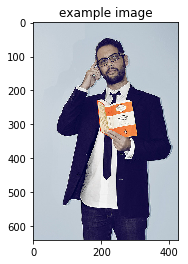

In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [54]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [55]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = "encoder-4.pkl"
decoder_file = "decoder-4.pkl"

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 672

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (embedding): Embedding(8855, 512)
  (lstm): LSTM(512, 672, batch_first=True)
  (fc1): Linear(in_features=672, out_features=8855, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [56]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 169, 77, 3, 1015, 6, 1318, 130, 285, 111, 32, 1179, 18, 1, 1, 18, 1, 1, 18]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [57]:
# TODO #4: Complete the function.
def clean_sentence(output):
    output = output[1:]
    sentence_length = output.index(1)
    sentence = " ".join(data_loader.dataset.vocab.idx2word[num_word] for ii, num_word in enumerate(output) 
                        if num_word != 1 and ii < sentence_length)
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [58]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a man in a suit and tie is looking at the camera .


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [59]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

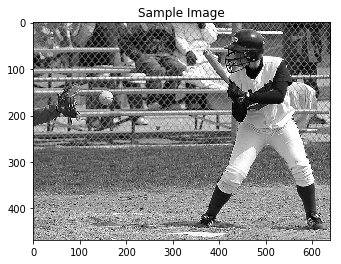

a man is swinging a baseball bat at a baseball field .


In [64]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

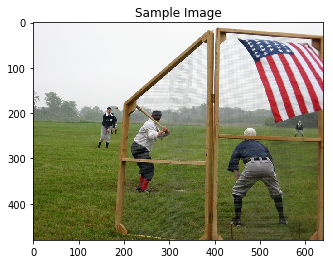

a man in a baseball uniform is throwing a baseball .


In [67]:
get_prediction()

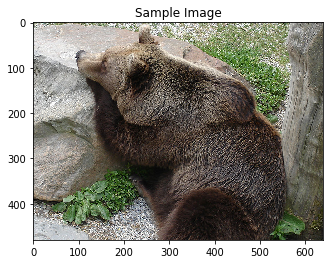

a brown bear is sitting on a rock


In [68]:
get_prediction()

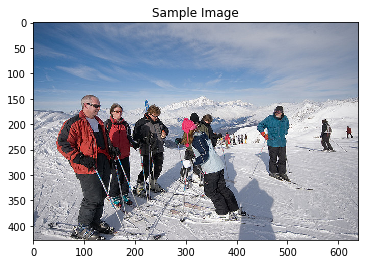

a group of people skiing on a snowy slope


In [69]:
get_prediction()

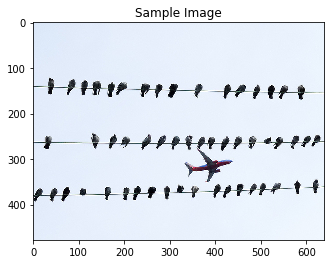

a large white and blue jet flying through the air


In [94]:
get_prediction()

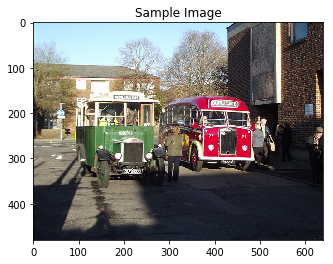

a red double decker bus driving down a street .


In [71]:
get_prediction()

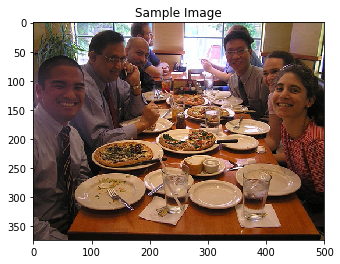

a group of people sitting around a table eating food .


In [73]:
get_prediction()

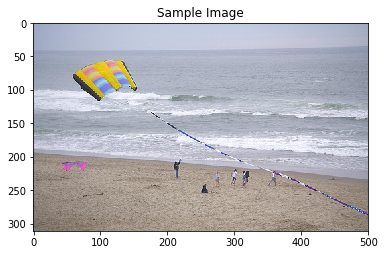

a group of people are flying a kite on the beach .


In [95]:
get_prediction()

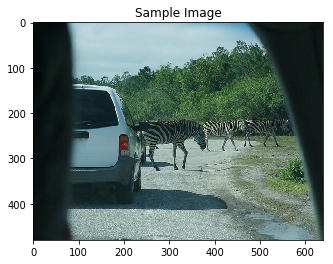

a couple of zebras are standing in a field


In [81]:
get_prediction()

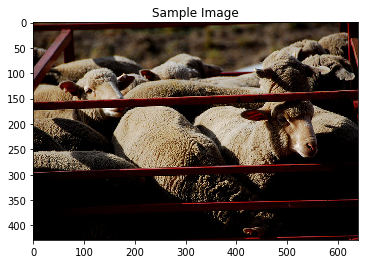

a large herd of sheep are gathered together .


In [83]:
get_prediction()

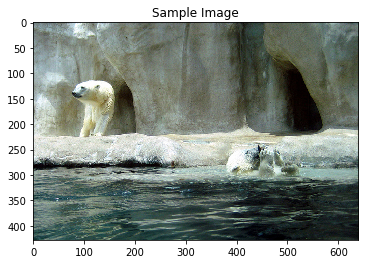

a polar bear is walking on a rocky ground .


In [85]:
get_prediction()

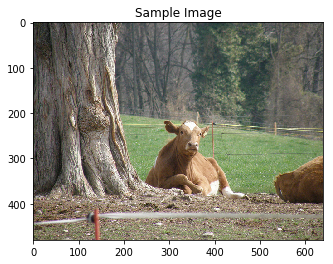

a brown horse standing on a lush green field .


In [87]:
get_prediction()

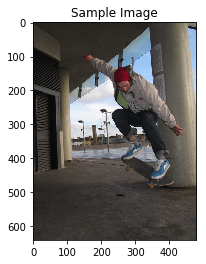

a man is doing a trick on a skateboard


In [88]:
get_prediction()

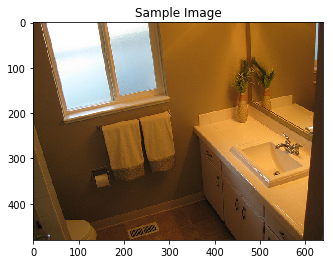

a bathroom with a sink , mirror , and shower .


In [93]:
get_prediction()

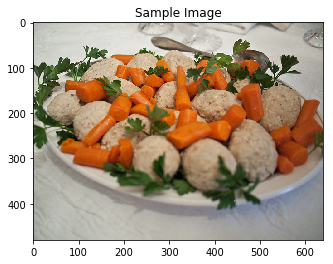

a plate of food with vegetables and meat


In [101]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

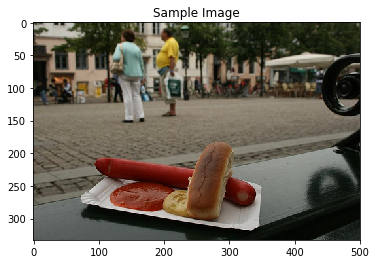

a man is holding a sandwich in his hands .


In [99]:
get_prediction()

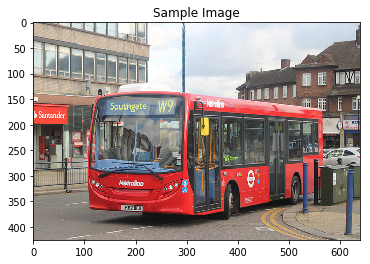

a large white bus on a city street .


In [100]:
get_prediction()

#### Tried with some images from the web

In [102]:
from PIL import Image
def wild_image(img_path):
    orig_image = Image.open(img_path).convert("RGB")
    def preprocess(img_path):
        image = Image.open(img_path).convert("RGB")
        
        transform = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224), 
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        image = transform(image)[:3, :, :].unsqueeze(0)
        return image
    
    image = preprocess(img_path)
    image = image.to(device)
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    

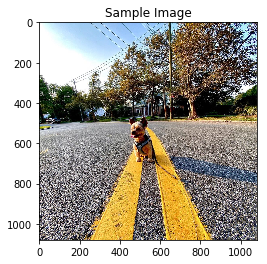

a person walking on a city street with a dog


In [106]:
wild_image("images/iphone-11-camera-quality.jpg")

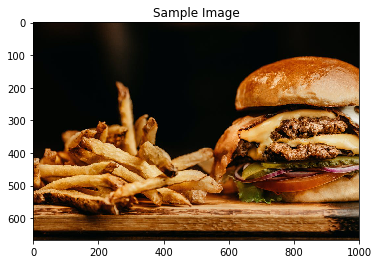

a plate of food with a sandwich and a bowl of soup .


In [109]:
wild_image("images/pexels-photo-2983101.jpeg")

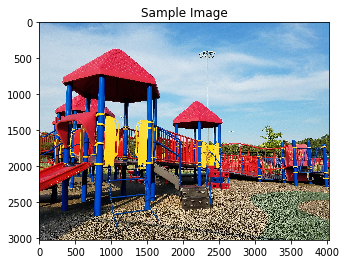

a red and white fire hydrant on a city street .


In [112]:
wild_image("images/pexels-meghan-riley-424827.jpg")

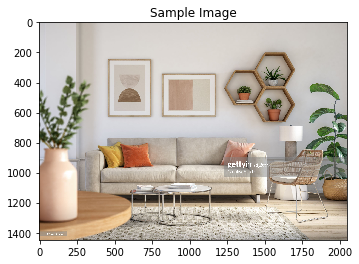

a living room with a couch and a table


In [113]:
wild_image("images/roo .jpg")

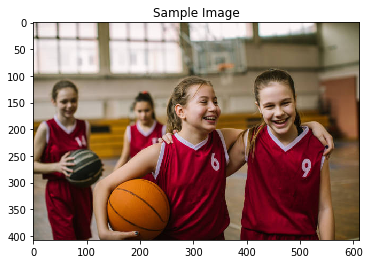

a group of people standing around a table with a cake .


In [114]:
wild_image("images/basket.jpg")

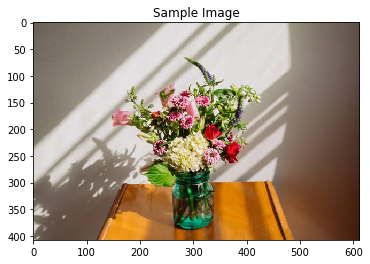

a vase with a flower in it and a glass of water


In [116]:
wild_image("images/vase.jpg")

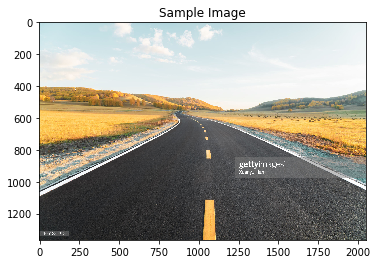

a large white airplane on a runway .


In [117]:
wild_image("images/road.jpg")

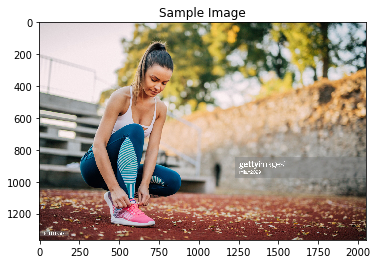

a woman in a blue dress is playing tennis


In [118]:
wild_image("images/shoe.jpg")